In [165]:
import json
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from pan25_genai_detection.evaluator import evaluator

In [166]:
OUT_DIR = Path('../data/pan-task-eval-out/')
OUT_DIR.mkdir(parents=True, exist_ok=True)

sns.set_context('paper', font_scale=1.2)
sns.set_style('whitegrid')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.linewidth'] = .75
plt.rcParams['patch.linewidth'] = .5
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['lines.dashed_pattern'] = (10, 5)
plt.rcParams['lines.linewidth'] = .75
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Libertinus Sans', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'

# Webis colours
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#90d7de',
    '#9ed977',
    '#ffab9e',
    '#d6acfa',
    '#ffc640',
    '#68b4c2',
    '#62ba61',
    '#ff6f52',
    '#bb86f3',
    '#e8a01d',
])

### Load Data

In [167]:
team_map = {
    'mdok': 'Macko',
    'diveye': 'Basani',
    'moadmoad': 'Liu',
    'yangjlg': 'Yang',
    'steely': 'Seeliger',
    'nexus-interrogators': 'Zaidi',
    'unibuc-nlp': 'Marchitan',
    'baseline-tf-idf': 'Baseline TF-IDF SVM',
    'cnlp-nits-pp': 'Sai Teja',
    'advacheck': 'Voznyuk',
    'iimasnlp': 'Valdez-Valenzuela',
    'sinai-inta': 'Jimeno-Gonzalez',
    'styloch': 'Ochab',
    'pindrop': 'Sun',
    'ds-gt-pan': 'Ostrower',
    'shushantatud': 'Pudasaini',
    'iunlp': 'Larson',
    's-titze': 'Titze',
    'baseline-binoculars-llama-3.1': 'Baseline Binoculars Llama3.1',
    'asdkklkk': 'Liang',
    'hiwiy': 'Huang',
    'baseline-ppmd': 'Baseline PPMd CBC',
    'team-a': 'Kumar',
    'felix-volpel': 'Völpel',
}

source_map = {
    'brennan-greenstadt': 'Brennan Greenstadt',
    'brennan-greenstadt-obfuscated': 'Brennan-Greenstadt (Obfuscated)',
    'riddell-juola': 'Riddell-Juola',
    'riddell-juola-o1-deepseek': 'Riddell-Juola (o1)',
    'riddell-juola-obfuscated': 'Riddell-Juola (Obfuscated)',
    'gutenberg-19c-fiction': 'Gutenberg Fiction',
    'gutenberg-19c-fiction-o1': 'Gutenberg Fiction (o1)',
    'gutenberg-19c-fiction-obfuscated': 'Gutenberg Fiction (Obfuscated)',
    'pan24-o1': 'PAN\'24 (o1)',
    'pan24-test': 'PAN\'24 Test',
    'eloquent': 'ELOQUENT',
}

In [168]:
def load_run_jsonl(infile):
    for l in open(infile):
        j = json.loads(l)
        obj = {k: v for k, v in j.items() if k in ['dataset', 'team', 'software', 'run_id']}
        obj['eval_field'] = 'all'
        obj['eval_value'] = 'all'
        eval_keys = [k for k in j['evaluation'] if k.startswith('_eval-')]
        if obj['team'] == 'baseline':
            if obj['software'] == 'baseline-binoculars-tiny-llama':
                # Skip inofficial baseline
                continue
            obj['team'] =  obj['software']
        obj['team'] = team_map.get(obj['team'], obj['team'])
        obj_all = obj.copy()
        obj_all.update({'resource_' + k: v for k, v in j['used_resources'].items()})
        obj_all.update({k: v for k, v in j['evaluation'].items() if k not in eval_keys})
        yield obj_all

        for k in eval_keys:
            obj['eval_field'] = k.replace('_eval-', '')
            for kv, v in j['evaluation'][k].items():
                obj['eval_value'] = kv if obj['eval_field'] != 'source' else source_map.get(kv, kv)
                obj.update(**v)
                yield obj.copy()

# Load run evaluations, but keep only last runif softwares were executed multiple times
df_run_eval_raw = (pd.DataFrame(load_run_jsonl('../data/tira/runs-gen-ai-authorship-verification/runs.jsonl'))
                   .sort_values('run_id')
                   .drop_duplicates(subset=['dataset', 'team', 'software', 'eval_field', 'eval_value'], keep='last')
                   .set_index(['dataset', 'team', 'software', 'run_id', 'eval_field', 'eval_value']))
_resource_cols = [c for c in df_run_eval_raw.columns if c.startswith('resource_')]
df_resources = df_run_eval_raw[_resource_cols].dropna()
df_run_eval_raw = df_run_eval_raw.drop(columns=_resource_cols)

# Keep only highest by mean score on main test set
softwares = set(i[1] for i in df_run_eval_raw.loc['pan25-generative-ai-detection-20250604-test']
                .query('eval_field == "all"')
                .groupby('team')
                .idxmax()['mean'])
df_run_eval_raw = df_run_eval_raw.query('software in @softwares')

# Drop "all"
df_run_eval_raw = df_run_eval_raw.query('eval_field != "all"')

In [169]:
# Load case ID map
id_map = {}
for f in Path('../data/sampled').glob('*-orig-ids.jsonl'):
    for l in open(f, 'r'):
        j = json.loads(l)
        assert j['id'] not in id_map
        id_map[j['id']] = j['orig_id']

In [170]:
# Load raw predictions and back-translate case IDs
df_pred_raw = []
for pt in tqdm(list(Path('../data/tira/runs-gen-ai-authorship-verification').glob('*/run.prototext')), desc='Loading raw predictions'):
    y = yaml.full_load(open(pt))
    try:
        t, s = df_run_eval_raw.xs((y['inputDataset'], y['runId']), level=['dataset', 'run_id']).index.unique().values[0][:2]
    except KeyError:
        # Software filtered
        continue
    df_pred_raw.append(pd.read_json(next(pt.parent.glob('output/*.jsonl')), lines=True)[['id', 'label']])
    df_pred_raw[-1]['dataset'] = y['inputDataset']
    df_pred_raw[-1]['run_id'] = y['runId']
    df_pred_raw[-1]['team'] = t if t != 'baseline' else s
    df_pred_raw[-1]['software'] = s
    df_pred_raw[-1]['id'] = df_pred_raw[-1]['id'].map(lambda x: id_map[x])

df_pred_raw = pd.concat(df_pred_raw).sort_values('id').set_index(['dataset', 'team', 'software', 'run_id', 'id'])

Loading raw predictions:   0%|          | 0/150 [00:00<?, ?it/s]

In [171]:
# Merge ELOQUENT submissions
rows = []
for (t, s), d in df_pred_raw.query('dataset.str.contains("-eloquent-")').groupby(['team', 'software']):
    r = {
            'dataset': 'pan25-generative-ai-detection-eloquent-test-all',
            'team': t,
            'software': s,
            'run_id': tuple(d.index.get_level_values('run_id').unique()),
            'eval_field': 'model',
        }

    for i, d_ in enumerate([d.query('id.str.startswith("eloquent25/human/")'),
                            d.query('not id.str.startswith("eloquent25/human/")'),
                            d]):
        if i in [0, 1]:
            r_ = {
                **r,
                'eval_field': 'model',
                'eval_value': 'eloquent-human' if i == 0 else 'eloquent-llm',
                **{k: (np.float64(v) if type(v) is not list else v)
                   for k, v in evaluator.evaluate_all(np.array([i] * len(d_)), np.squeeze(d_['label'].values)).items()},
            }
        else:
            r_ = {
                **r,
                'eval_field': 'source',
                'eval_value': 'ELOQUENT',
                **evaluator.evaluate_all(
                    d_.reset_index()['id'].str.startswith('eloquent25/human/').values,
                    np.squeeze(d_['label'].values)),
            }

        rows.append(pd.Series(list(r_.values()), index=list(r_.keys())))

df_run_eval = pd.concat([
    df_run_eval_raw.query('not dataset.str.contains("-eloquent-")'),
    pd.DataFrame(rows).set_index(df_run_eval_raw.index.names)
])

# Fix F1 and F0.5u NaN values
def _fix_f1_nan(s):
    if np.isnan(s['f1']) and s['c@1'] == 1.0:
        s['f1'] = 1.0
        s['f05u'] = 1.0
    return s

df_run_eval = df_run_eval.apply(_fix_f1_nan, axis=1)

def _recalc_means(s):
    s['mean'] = float(np.mean([v for k, v in s.dropna().items() if type(v) is float and k != 'mean']))
    return s

# Update means
df_run_eval = df_run_eval.apply(_recalc_means, axis=1)

# Calculate FPR, FNR
df_run_eval['fpr'] = df_run_eval['confusion'].map(lambda s: s[0][1] / np.sum(s[0]) if np.sum(s[0]) else np.nan)
df_run_eval['fnr'] = df_run_eval['confusion'].map(lambda s: s[1][0] / np.sum(s[1]) if np.sum(s[1]) else np.nan)
df_run_eval['human_prec'] = df_run_eval['confusion'].map(lambda s: s[0][0] / (s[0][0] + s[1][0]) if (s[0][0] + s[1][0]) else np.nan)
df_run_eval['human_rec'] = df_run_eval['confusion'].map(lambda s: s[0][0] / np.sum(s[0]) if np.sum(s[0]) else np.nan)

### PAN Evaluation

In [172]:
print('Datasets:\n - ', end='')
print('\n - '.join(df_run_eval.query('eval_field == "source"').reset_index()['eval_value'].unique()))

Datasets:
 - Brennan Greenstadt
 - Riddell-Juola (Obfuscated)
 - Riddell-Juola (o1)
 - Riddell-Juola
 - PAN'24 Test
 - PAN'24 (o1)
 - Gutenberg Fiction (Obfuscated)
 - Gutenberg Fiction (o1)
 - Gutenberg Fiction
 - Brennan-Greenstadt (Obfuscated)
 - ELOQUENT


In [173]:
pan_leaderboard_source = df_run_eval.query('eval_field == "source"').groupby(['team', 'software']).mean(numeric_only=True).sort_values(['mean'], ascending=False)
pan_leaderboard_source.reset_index().to_html(OUT_DIR / 'leaderboard.html', float_format=lambda f: f'{f:.3f}')
pan_leaderboard_source.round(3)

,,roc-auc,brier,c@1,f1,f05u,mean,fpr,fnr,human_prec,human_rec
team,software,,,,,,,,,,
Macko,mdok,0.853,0.896,0.894,0.898,0.903,0.899,0.147,0.108,0.795,0.853
Seeliger,fine-roberta,0.842,0.879,0.877,0.865,0.881,0.880,0.158,0.151,0.653,0.842
Zaidi,sensitive-liason,0.865,0.874,0.870,0.860,0.881,0.879,0.131,0.159,0.580,0.869
Yang,pink-condenser,0.845,0.878,0.871,0.856,0.881,0.877,0.098,0.172,0.648,0.902
Sai Teja,tomato-conduction,0.825,0.873,0.873,0.854,0.882,0.874,0.078,0.176,0.576,0.922
Marchitan,tangy-arch,0.828,0.885,0.864,0.845,0.876,0.872,0.081,0.187,0.571,0.919
Liu,modernbert,0.822,0.866,0.865,0.855,0.882,0.871,0.092,0.175,0.574,0.908
Valdez-Valenzuela,isg-graph-v3,0.838,0.868,0.856,0.851,0.877,0.869,0.122,0.171,0.575,0.878
bohan-li,distinct-dachshund,0.848,0.858,0.852,0.847,0.870,0.866,0.144,0.174,0.573,0.856


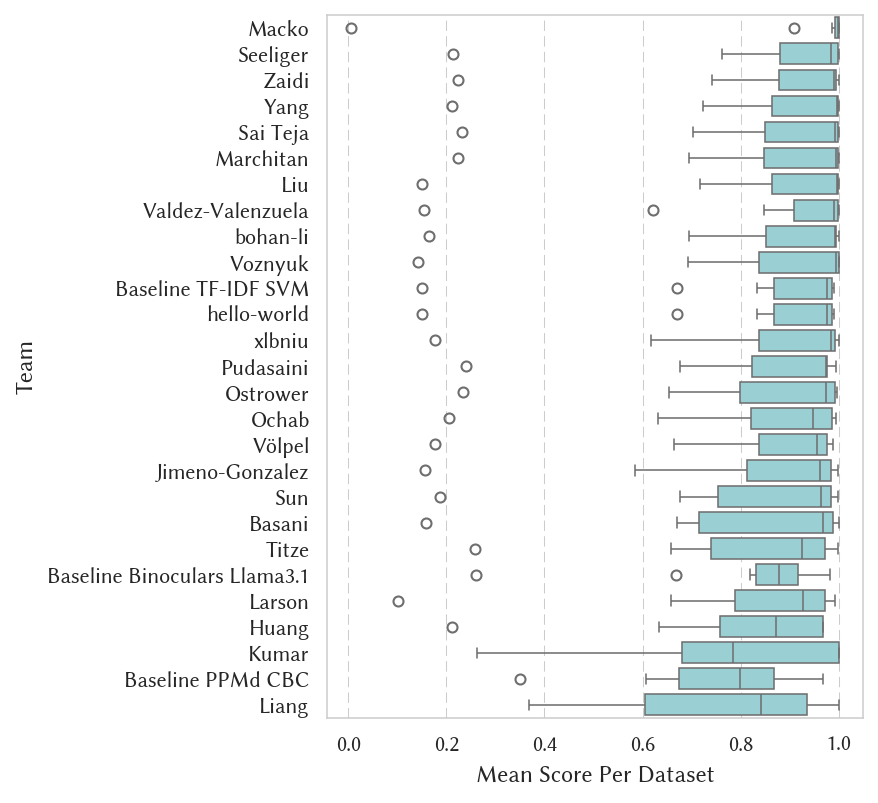

In [174]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='mean', y='team', linewidth=.75, order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Mean Score Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source.pdf')
plt.show()

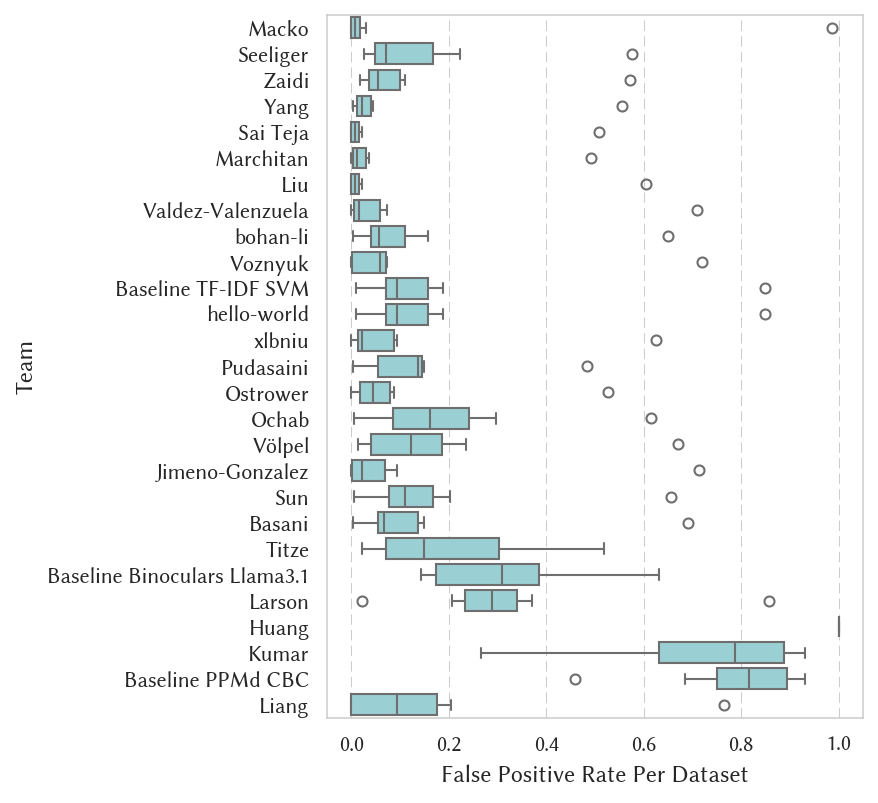

In [175]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='fpr', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Positive Rate Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_fpr.pdf')
plt.show()

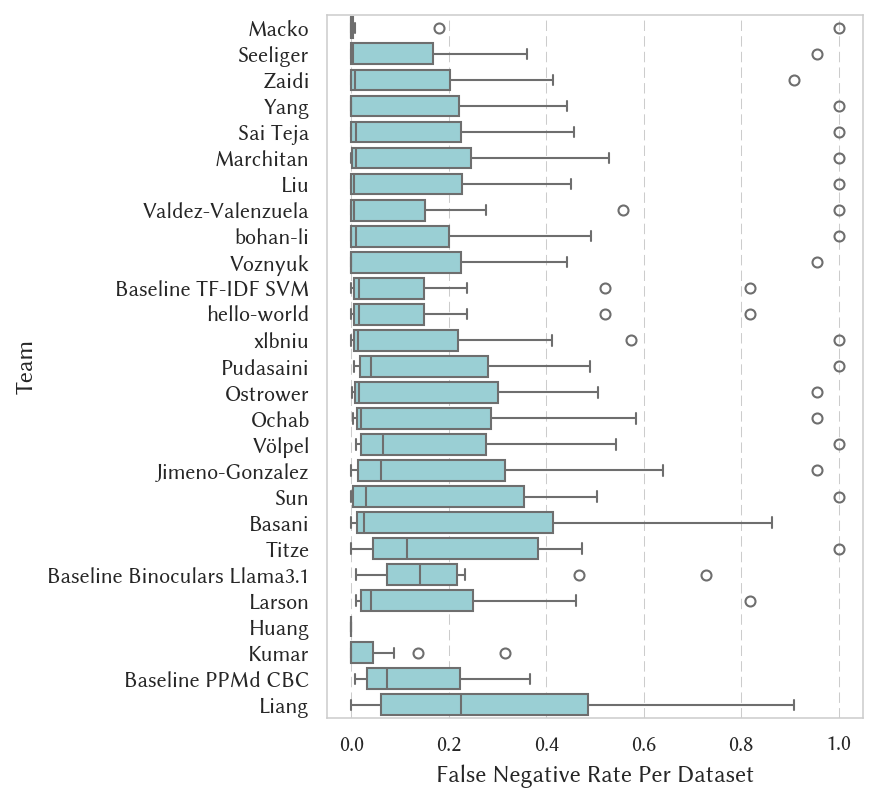

In [176]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='fnr', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Negative Rate Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_fpr.pdf')
plt.show()

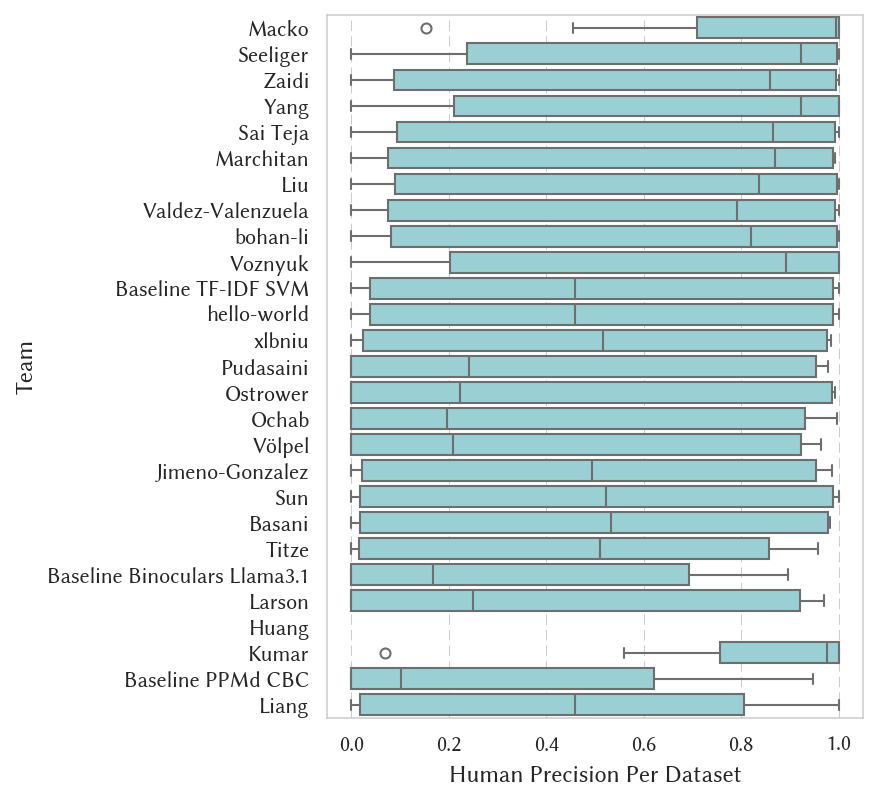

In [177]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='human_prec', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Human Precision Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_prec.pdf')
plt.show()

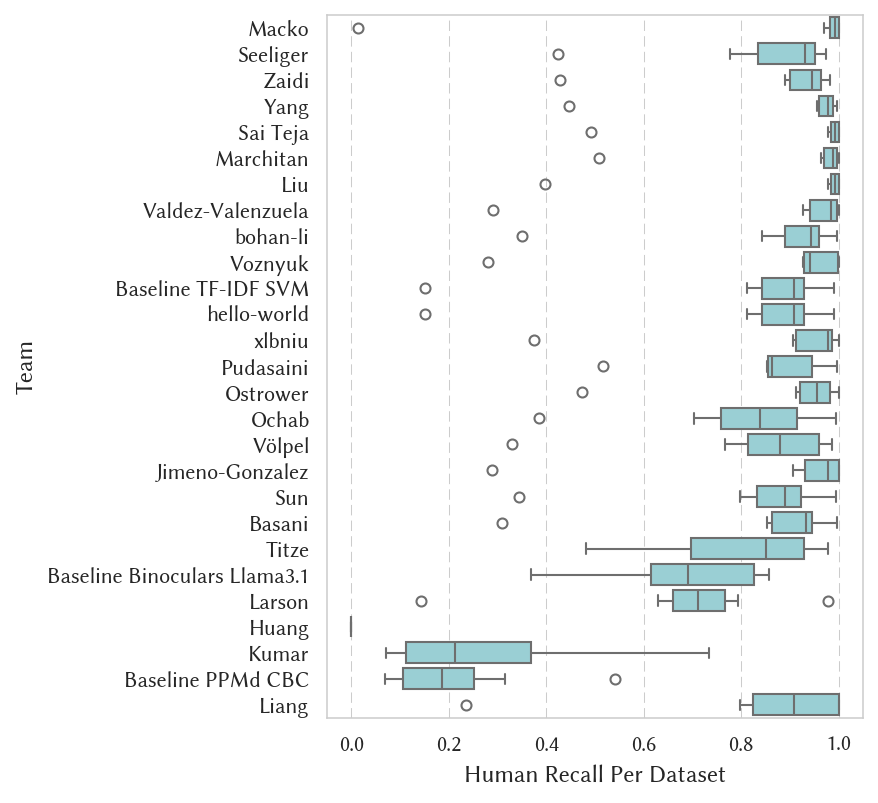

In [179]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='human_rec', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Human Recall Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_rec.pdf')
plt.show()

In [180]:
pan_leaderboard_model = df_run_eval.query('eval_field == "model"').groupby(['team', 'software']).mean(numeric_only=True).sort_values(['mean'], ascending=False)
pan_leaderboard_model.round(3)

,,roc-auc,brier,c@1,f1,f05u,mean,fpr,fnr,human_prec,human_rec
team,software,,,,,,,,,,
Macko,mdok,NaN,0.970,0.966,0.953,0.964,0.963,0.003,0.035,0.250,0.997
Huang,connected-svn,NaN,0.855,0.949,0.949,0.949,0.925,1.000,0.000,NaN,0.000
Kumar,deafening-template,NaN,0.868,0.868,0.883,0.908,0.882,0.852,0.093,0.125,0.148
Larson,persistent-strut,NaN,0.873,0.873,0.871,0.909,0.881,0.151,0.126,0.062,0.849
Seeliger,fine-roberta,NaN,0.859,0.857,0.842,0.883,0.860,0.045,0.149,0.111,0.955
Baseline Binoculars Llama3.1,baseline-binoculars-llama-3.1,NaN,0.865,0.827,0.833,0.884,0.852,0.237,0.165,0.065,0.763
Baseline PPMd CBC,baseline-ppmd,NaN,0.828,0.831,0.836,0.881,0.844,0.700,0.126,0.077,0.300
hello-world,tart-objective,NaN,0.877,0.841,0.821,0.840,0.843,0.118,0.142,0.100,0.882
Baseline TF-IDF SVM,baseline-tf-idf,NaN,0.877,0.841,0.821,0.840,0.843,0.118,0.142,0.100,0.882


In [181]:
pan_leaderboard_genre = df_run_eval.query('eval_field == "genre"').groupby(['team', 'software']).mean(
    numeric_only=True).sort_values(['mean'], ascending=False)
pan_leaderboard_genre.round(3)

,,roc-auc,brier,c@1,f1,f05u,mean,fpr,fnr,human_prec,human_rec
team,software,,,,,,,,,,
Macko,mdok,0.996,0.987,0.985,0.991,0.994,0.991,0.009,0.013,0.890,0.991
Seeliger,fine-roberta,0.950,0.924,0.922,0.947,0.964,0.943,0.081,0.072,0.784,0.919
Liu,modernbert,0.974,0.914,0.913,0.940,0.970,0.943,0.006,0.094,0.627,0.994
Yang,pink-condenser,0.966,0.920,0.913,0.940,0.968,0.943,0.020,0.091,0.628,0.980
Zaidi,sensitive-liason,0.969,0.918,0.914,0.941,0.965,0.942,0.051,0.085,0.624,0.949
Sai Teja,tomato-conduction,0.939,0.913,0.913,0.940,0.970,0.937,0.006,0.094,0.626,0.994
hello-world,tart-objective,0.976,0.914,0.914,0.923,0.954,0.937,0.086,0.076,0.626,0.914
Baseline TF-IDF SVM,baseline-tf-idf,0.976,0.914,0.914,0.923,0.954,0.937,0.086,0.076,0.626,0.914
Marchitan,tangy-arch,0.968,0.916,0.899,0.927,0.962,0.935,0.011,0.109,0.619,0.989


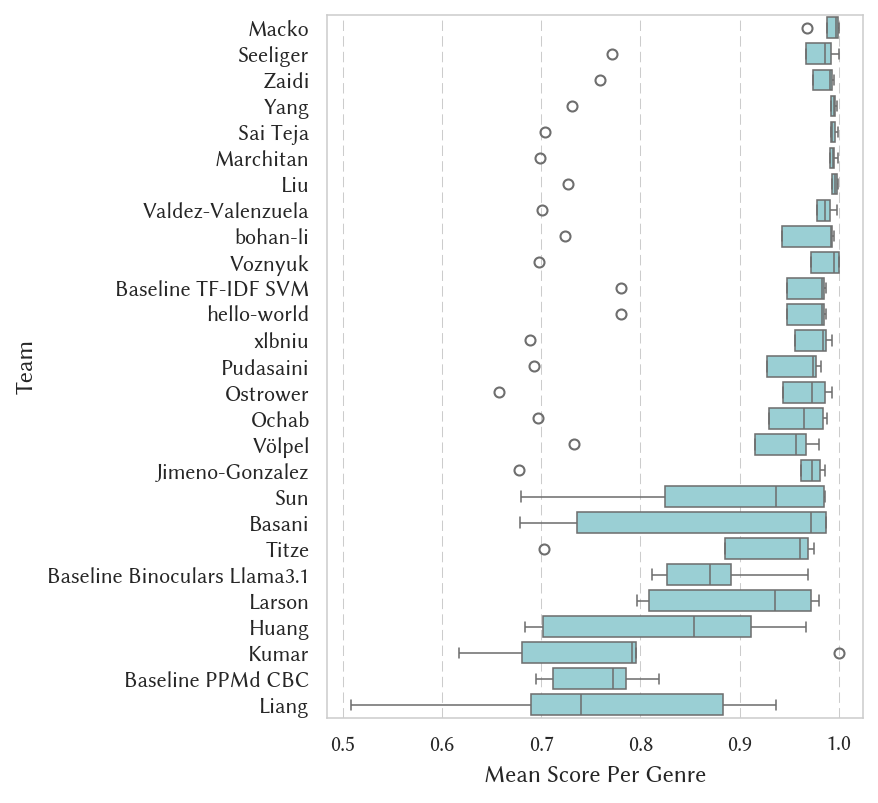

In [182]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "genre"'), x='mean', y='team', linewidth=.75, order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Mean Score Per Genre')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_genre.pdf')
plt.show()

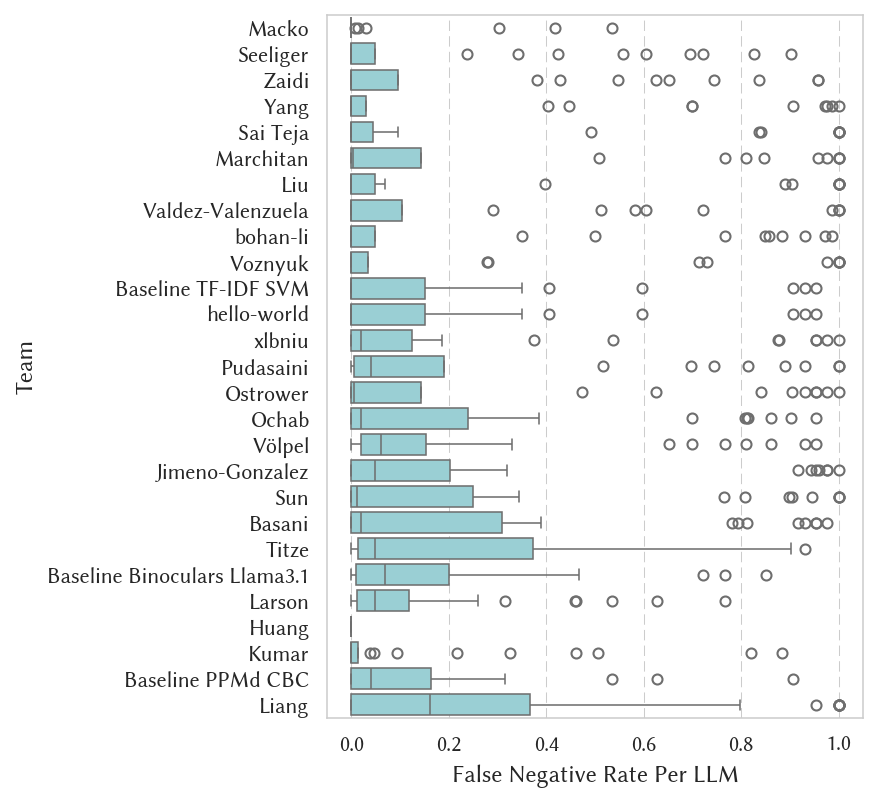

In [183]:
plt.figure(figsize=(6, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "model" and eval_value != "human"'), x='fnr', y='team', linewidth=.75, order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Negative Rate Per LLM')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_fnr.pdf')
plt.show()

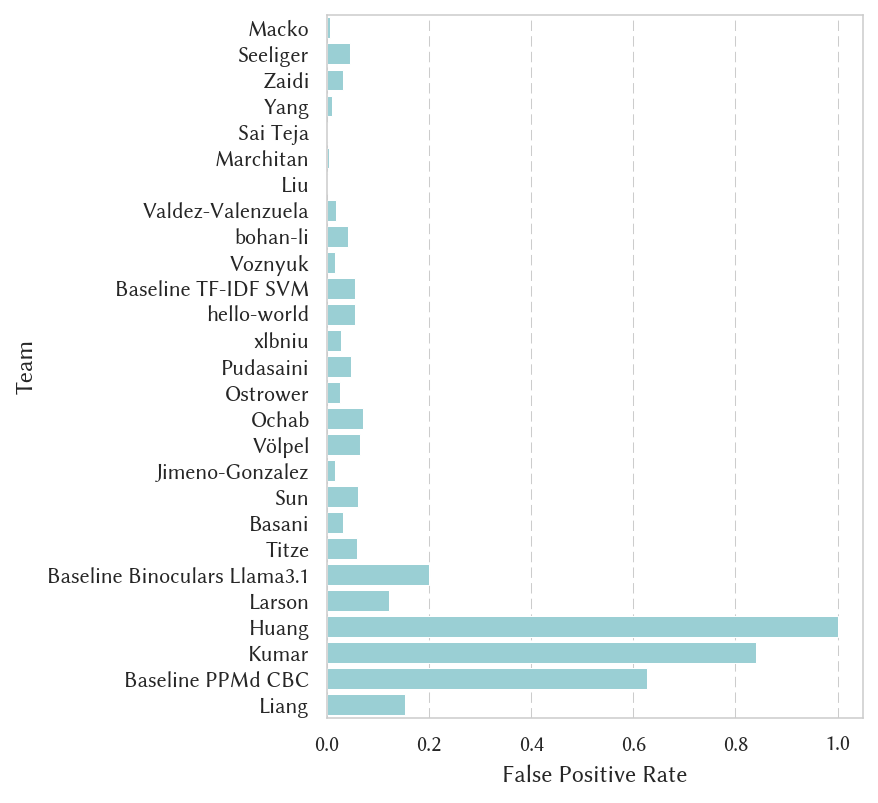

In [184]:
plt.figure(figsize=(6, 5.5))
sns.barplot(df_run_eval.query('eval_field == "model" and eval_value == "human"'), x='fpr', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Positive Rate')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_fpr.pdf')
plt.show()

In [185]:
pan_dataset_difficulty_all = df_run_eval.query('eval_field == "source"')[['brier', 'c@1', 'fpr', 'fnr']]
pan_dataset_difficulty_all['brier'] = 1.0 - pan_dataset_difficulty_all['brier']
pan_dataset_difficulty_all['c@1'] = 1.0 - pan_dataset_difficulty_all['c@1']
pan_dataset_difficulty = pan_dataset_difficulty_all.groupby(['eval_value']).median(numeric_only=True).sort_values(['c@1'], ascending=False)
pan_dataset_difficulty.round(3)

,brier,c@1,fpr,fnr
eval_value,,,,
ELOQUENT,0.557,0.651,0.649,0.955
Riddell-Juola (Obfuscated),0.379,0.426,0.074,0.442
Brennan-Greenstadt (Obfuscated),0.353,0.397,0.044,0.443
PAN'24 Test,0.061,0.048,0.088,0.007
PAN'24 (o1),0.046,0.031,NaN,0.030
Riddell-Juola,0.024,0.024,0.125,0.002
Gutenberg Fiction,0.017,0.014,0.005,0.017
Brennan Greenstadt,0.013,0.011,0.057,0.002
Gutenberg Fiction (Obfuscated),0.030,0.010,NaN,0.010


In [186]:
teams_top10 = pan_leaderboard_source.index.get_level_values('team')[:10]
pan_dataset_difficulty_top10_all = pan_dataset_difficulty_all.query('team in @teams_top10')
pan_dataset_difficulty_top10 = pan_dataset_difficulty_top10_all.groupby(['eval_value']).median(numeric_only=True).sort_values(['c@1'], ascending=False)
pan_dataset_difficulty_top10.round(3)

,brier,c@1,fpr,fnr
eval_value,,,,
ELOQUENT,0.614,0.617,0.589,1.000
Riddell-Juola (Obfuscated),0.410,0.426,0.037,0.442
Brennan-Greenstadt (Obfuscated),0.352,0.362,0.044,0.410
PAN'24 Test,0.021,0.022,0.040,0.004
Gutenberg Fiction (Obfuscated),0.008,0.010,NaN,0.010
PAN'24 (o1),0.010,0.010,NaN,0.010
Gutenberg Fiction,0.007,0.007,0.003,0.009
Riddell-Juola,0.003,0.003,0.012,0.000
Brennan Greenstadt,0.002,0.001,0.007,0.000


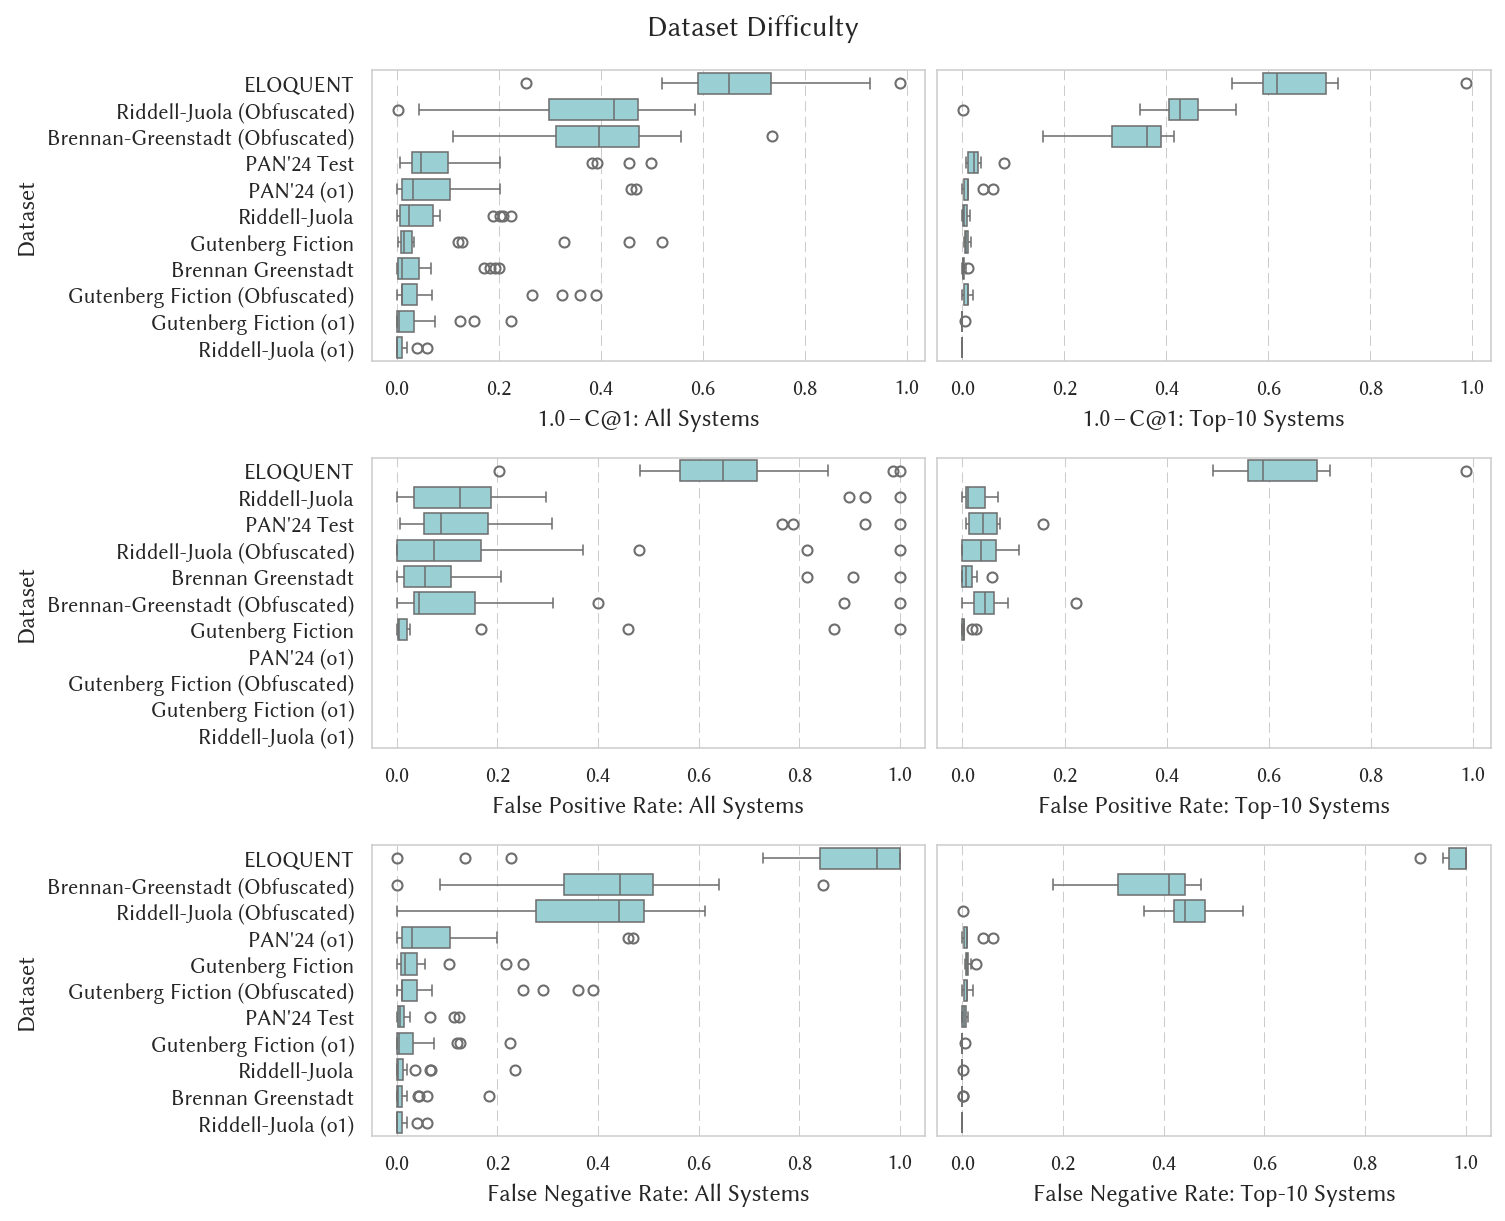

In [187]:
def _plt_dataset_difficulty(ax, df, field, xlabel, order, group_field='eval_value'):
    sns.boxplot(df, ax=ax, x=field, y=group_field, linewidth=.75, order=order)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Dataset')

fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharey='row')

_plt_dataset_difficulty(axs[0][0],
                        pan_dataset_difficulty_all,
                        'c@1',
                        '1.0 – C@1: All Systems',
                        pan_dataset_difficulty.index)
_plt_dataset_difficulty(axs[0][1],
                        pan_dataset_difficulty_top10_all,
                        'c@1',
                        '1.0 – C@1: Top-10 Systems',
                        pan_dataset_difficulty.index)

_plt_dataset_difficulty(axs[1][0],
                        pan_dataset_difficulty_all,
                        'fpr',
                        'False Positive Rate: All Systems',
                        pan_dataset_difficulty.sort_values('fpr', ascending=False).index)
_plt_dataset_difficulty(axs[1][1],
                        pan_dataset_difficulty_top10_all,
                        'fpr',
                        'False Positive Rate: Top-10 Systems',
                        pan_dataset_difficulty.sort_values('fpr', ascending=False).index)

_plt_dataset_difficulty(axs[2][0],
                        pan_dataset_difficulty_all,
                        'fnr',
                        'False Negative Rate: All Systems',
                        pan_dataset_difficulty.sort_values('fnr', ascending=False).index)
_plt_dataset_difficulty(axs[2][1],
                        pan_dataset_difficulty_top10_all,
                        'fnr',
                        'False Negative Rate: Top-10 Systems',
                        pan_dataset_difficulty.sort_values('fnr', ascending=False).index)

plt.suptitle('Dataset Difficulty', y=1.003)
plt.tight_layout(pad=.5, h_pad=1.1)
plt.savefig(OUT_DIR / 'pan_dataset_difficulty.pdf')
plt.show()

### ELOQUENT Evaluation

In [188]:
eloquent_team_map = {
    'adhd': 'adhd',
    'homoglyph': 'Homoglyph',
    'human': 'Human',
    'humanaizers-0': 'HumanAIzers-0',
    'humanaizers-1': 'HumanAIzers-1',
    'humanaizers-2': 'HumanAIzers-2',
    'humanaizers-3': 'HumanAIzers-3',
    'junlp_ss': 'JUNLP_SS',
    'moa': 'Moa',
    'pjs-team-v1': 'PJs-team-v1',
    'pjs-team-v2': 'PJS-team-v2',
    'teamutk': 'TeamUTK',
    'teamutk_bis': 'TeamUTK_bis',
    'translation': 'Translation'
}

df_pred_raw_eloquent = df_pred_raw.query('dataset.str.contains("-eloquent-")').copy()
df_pred_raw_eloquent['eloquent_team'] = df_pred_raw_eloquent.index.get_level_values('id').map(lambda x: eloquent_team_map.get(x.split('/')[1]))
df_pred_raw_eloquent.set_index('eloquent_team', inplace=True, append=True)
df_pred_raw_eloquent.to_csv('../data/tira/eloquent-pred-raw.csv')
df_pred_raw_eloquent.round(3)

label
dataset                                            team                software           run_id              id                         eloquent_team       
pan25-generative-ai-detection-eloquent-20250610... Macko               mdok               2025-06-11-00-34-20 eloquent25/adhd/030        adhd           1.000
                                                   Yang                pink-condenser     2025-06-11-00-40-52 eloquent25/adhd/030        adhd           1.000
                                                   Larson              persistent-strut   2025-06-11-00-34-11 eloquent25/adhd/030        adhd           0.000
                                                   bohan-li            distinct-dachshund 2025-06-11-00-10-49 eloquent25/adhd/030        adhd           1.000
                                                   Liu                 modernbert         2025-06-11-00-34-33 eloquent25/adhd/030        adhd           0.996
...                                                                                                                                                       ...
pan25-generative-ai-detection-eloquent-20250605... Marchitan           tangy-arch         2025-06-05-13-14-07 eloquent25/translation/052 Translation    0.004
                                                   Baseline TF-IDF SVM baseline-tf-idf    2025-06-05-11-20-38 eloquent25/translation/052 Translation    0.374
                                                   Liang               chromatic-fruit    2025-06-05-11-20-25 eloquent25/translation/052 Translation    0.000
                                                   hello-world         tart-objective     2025-06-05-12-11-02 eloquent25/translation/052 Translation    0.374
                                                   Völpel              crabby-announcer   2025-06-05-13-34-59 eloquent25/translation/052 Translation    0.997

[8289 rows x 1 columns]

In [189]:
df_run_eval_eloquent = []
for ds in df_pred_raw_eloquent.index.get_level_values('eloquent_team').unique():
    for t in df_pred_raw_eloquent.index.get_level_values('team').unique():
        p = df_pred_raw_eloquent.query('eloquent_team == @ds and team == @t')
        d = {k: v for k, v in evaluator.evaluate_all(np.array([ds != 'Human'] * len(p)), p['label']).items() if k in ['brier', 'c@1', 'confusion']}
        d['brier'] = 1.0 - d['brier']
        d['c@1'] = 1.0 - d['c@1']
        d['pan_team'] = t
        d['dataset'] = ds
        df_run_eval_eloquent.append(d)
df_run_eval_eloquent = pd.DataFrame(df_run_eval_eloquent).set_index(['dataset', 'pan_team']).sort_values('c@1', ascending=False)
df_run_eval_eloquent['fpr'] = df_run_eval_eloquent['confusion'].map(lambda s: s[0][1] / np.sum(s[0]) if np.sum(s[0]) else 0)
df_run_eval_eloquent['fnr'] = df_run_eval_eloquent['confusion'].map(lambda s: s[1][0] / np.sum(s[1]) if np.sum(s[1]) else 0)

eloquent_leaderboard = df_run_eval_eloquent.groupby('dataset').median(numeric_only=True).sort_values('c@1', ascending=False)
eloquent_leaderboard.round(3)

,brier,c@1,fpr,fnr
dataset,,,,
HumanAIzers-0,0.716,0.818,0.000,0.773
Translation,0.716,0.818,0.000,0.773
PJS-team-v2,0.530,0.727,0.000,0.727
JUNLP_SS,0.362,0.535,0.000,0.455
HumanAIzers-1,0.262,0.409,0.000,0.409
Homoglyph,0.262,0.409,0.000,0.409
PJs-team-v1,0.180,0.273,0.000,0.227
TeamUTK_bis,0.182,0.227,0.000,0.227
adhd,0.154,0.182,0.000,0.182


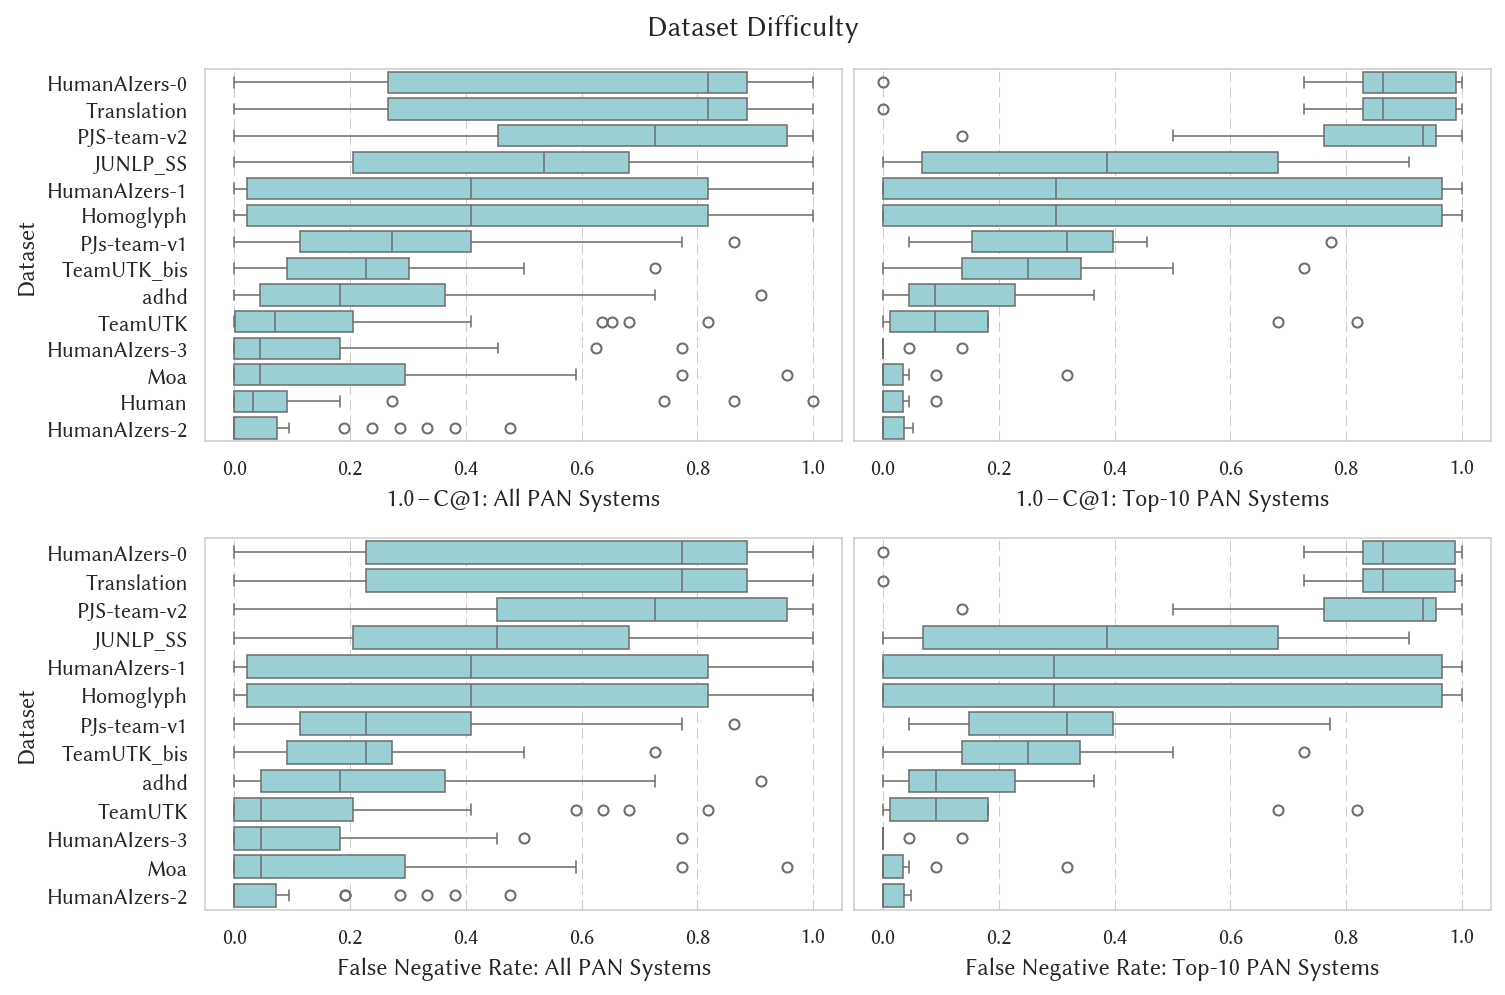

In [190]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6.5), sharey='row')

_plt_dataset_difficulty(axs[0][0],
                        df_run_eval_eloquent,
                        'c@1',
                        '1.0 – C@1: All PAN Systems',
                        eloquent_leaderboard.index,
                        group_field='dataset')
_plt_dataset_difficulty(axs[0][1],
                        df_run_eval_eloquent.query('pan_team in @teams_top10'),
                        'c@1',
                        '1.0 – C@1: Top-10 PAN Systems',
                        eloquent_leaderboard.index,
                        group_field='dataset')

_plt_dataset_difficulty(axs[1][0],
                        df_run_eval_eloquent.query('dataset != "Human"'),
                        'fnr',
                        'False Negative Rate: All PAN Systems',
                        [i for i in eloquent_leaderboard.sort_values('fnr', ascending=False).index if i != 'Human'],
                        group_field='dataset')
_plt_dataset_difficulty(axs[1][1],
                        df_run_eval_eloquent.query('dataset != "Human" and pan_team in @teams_top10'),
                        'fnr',
                        'False Negative Rate: Top-10 PAN Systems',
                        [i for i in eloquent_leaderboard.sort_values('fnr', ascending=False).index if i != 'Human'],
                        group_field='dataset')

plt.suptitle('Dataset Difficulty', y=1.003)
plt.tight_layout(pad=.5, h_pad=1.1)
plt.savefig(OUT_DIR / 'pan_dataset_difficulty.pdf')
plt.show()